# Learning about Q-learning

Opskriver profitfunktion som i Klein (2021)

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numba import njit
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

In [3]:
@njit
def demand(p1t, p2t):
    if (p1t < p2t):
        return 1 - p1t
    elif (p1t == p2t):
        return 0.5 * (1 - p1t)
    elif (p1t > p2t):
        return 0

In [4]:
@njit
def profit(p1t, p2t):
    return p1t * demand(p1t, p2t)

In [5]:
@njit
def Q(p_it_idx, s_t_idx, i, t, alpha, delta, p_table, Q_table, prices, s_next) -> float: # p_table contains p and s (opponent price)
    if i == 0:
        j = 1
    else:
        j = 0
    prev_est = Q_table[p_it_idx, s_t_idx]
    #s_t_next_idx = np.where(prices == p_table[j, t+1])[0][0] # index for next state (s_{t+1})
    # maxed_Q = max(Q_table[:, s_t_next_idx])
    s_next_index=np.where(prices == s_next)[0][0] 
    maxed_Q = max(Q_table[:, s_next_index])
    #print(maxed_Q)
    #print("firm ", i, "sets price :", p_table[i, t])
    #print("firm ", j, "sets price :", p_table[j, t])
    #print("profit (i, t)=" ,(i,t), ": ", profit(p_table[i, t], p_table[j, t]))
    #new_est = profit(p_table[i, t], p_table[j, t]) + delta * profit(p_table[i, t], p_table[j, t+1]) + delta**2 * maxed_Q
    new_est = profit(p_table[i, t], p_table[j, t]) + delta * profit(p_table[i, t], s_next) + delta**2 * maxed_Q
    return (1 - alpha) * prev_est + alpha * new_est

In [6]:
@njit
def set_price2(i, t, p_table, Q_table, prices, epsilon):
    if epsilon >= np.random.uniform(0,1):
        return np.random.choice(prices)
    else:
        if i == 0:
            j = 1
        else:
            j = 0
        s_t_idx = np.where(prices == p_table[j, t-1])[0][0] # our state (opponent's price)
        maxedQ_idx = np.argmax(Q_table[:, s_t_idx])
        #print("s_t_idx ", np.where(prices == p_table[j, t-1])[0][0])
        #print("opponentprice: ", p_table[j, t-1])
        #print("maxedQ_idx: ", maxedQ_idx, "i = ", i, "Q-value: ", Q_table[maxedQ_idx, s_t_idx])
        #print("Q_table ", i, "t = ", t, ": \n", Q_table)
        print("\nRow in Qtable in question\n",Q_table[:, s_t_idx])
        return prices[maxedQ_idx]

In [7]:
@njit
def set_price(i, t, p_table, Q_table, prices, epsilon):
    if epsilon >= np.random.uniform(0,1):
        return np.random.choice(prices)
    else:
        if i == 0:
            j = 1
        else:
            j = 0
        s_t_idx = np.where(prices == p_table[j, t-1])[0][0] # our state (opponent's price)
        maxedQ_idx = np.argmax(Q_table[:, s_t_idx])
        #print("s_t_idx ", np.where(prices == p_table[j, t-1])[0][0])
        #print("opponentprice: ", p_table[j, t-1])
        #print("maxedQ_idx: ", maxedQ_idx, "i = ", i, "Q-value: ", Q_table[maxedQ_idx, s_t_idx])
        #print("Q_table ", i, "t = ", t, ": \n", Q_table)
        return prices[maxedQ_idx]

In [8]:
@njit
def curr_prof(p_table, profits, i, t):
    if i == 0:
        j = 1
    else:
        j = 0
    profits[i, t] = profit(p_table[i,t], p_table[j,t])
    return 
# i=0
# t=0
# profits = np.zeros((2,1))
# p_table = np.zeros((2,1))
# p_table[0,0]=1/3
# p_table[1,0]=1/3
# curr_prof(p_table, profits, i, t)
# print(profits)

In [9]:
@njit
def bertrand_simulation(alpha, delta, T, prices):
    
    i = 0
    j = 1
    
    t = 0
    # calculate the decay parameter theta
    theta = -(1/1000000)**(1/T) + 1
    epsilon = (1 - theta)**t

    p = len(prices)
    Q_table1 = np.zeros((p, p)) # |P| x |S| matrix
    Q_table2 = np.zeros((p, p)) 

    p_table = np.zeros((2,T))
    profits = np.zeros((2,T))
    avg_profs1 = []
    avg_profs2 = []

    p_table[i, t] = np.random.choice(prices) # firm 1 sets price
    t += 1
    p_table[j, t] = np.random.choice(prices) # firm 2 sets price
    p_table[i, t] = p_table[i, t-1]
    t += 1 # now t = 2

    while t < T:

        if i == 0: # update firm 0
            # exploration module
            p_it_idx = np.where(prices == p_table[i, t-2])[0][0]
            s_t_idx =  np.where(prices == p_table[j, t-2])[0][0]
            s_next = set_price(j, t, p_table, Q_table2, prices, epsilon)
            Q_table1[p_it_idx, s_t_idx] = Q(p_it_idx, s_t_idx, i, t-2, alpha, delta, p_table, Q_table1, prices, s_next)
            
            
            # action module
            p_table[i, t] = set_price(i, t, p_table, Q_table1, prices, epsilon)
            p_table[j, t] = p_table[j, t-1]



            # write profits for firm 0
            curr_prof(p_table, profits, 0, t)
            curr_prof(p_table, profits, 1, t)

            #compute avg profitability of last 1000 runs
            if t % 50000 == 0:
                profitability = np.sum(profits[i, (t-1000):t])/1000
                avg_profs1.append(profitability)
        else: # update firm 1
            # exploration module
            p_it_idx = np.where(prices == p_table[i, t-2])[0][0]
            s_t_idx =  np.where(prices == p_table[j, t-2])[0][0]
            s_next = set_price(j, t, p_table, Q_table1, prices, epsilon)
            Q_table2[p_it_idx, s_t_idx] = Q(p_it_idx, s_t_idx, i, t-2, alpha, delta, p_table, Q_table2, prices, s_next)

            # action module
            p_table[i, t] = set_price(i, t, p_table, Q_table2, prices, epsilon)
            p_table[j, t] = p_table[j, t-1]

            # write profits for firm 1
            curr_prof(p_table, profits, 0, t)
            curr_prof(p_table, profits, 1, t)
            if t % 50000 == 1:    
                profitability = np.sum(profits[i, (t-1000):t])/1000
                avg_profs2.append(profitability)

        # calculate new epsilon using decay parameter
        epsilon = (1 - theta)**t

        tmp = i
        i = j
        j = tmp
        t += 1
    return p_table, avg_profs1, avg_profs2

In [10]:
# #### UNCOMMENT FOR COMPLICITY
# #set parameters
# #optionally use a fixed seed
# 
# alpha, delta = 0.3, 0.95  # values from Klein(2021)
# T = 500000
# N = 100
# jointprofitability=[]
# complicity=[]
# for n in range(0, N):
#     p_table, avg_profs1, avg_profs2 = bertrand_simulation(alpha, delta, T)
#     jointprofitability.append((avg_profs1[-1]+avg_profs2[-1])/2)
#     complicity.append(((avg_profs1[-1]+avg_profs2[-1])/2)/0.125)
#   
# print(complicity)
# plt.hist(complicity, bins=[i/10 for i in range(5,11)],rwidth=0.8)
# plt.xlabel('Delta')
# plt.ylabel('Frequency')
# plt.title('Distribution of Delta 100 runs 2 firms')
# plt.show()
# 

In [11]:
# ##### UNCOMMENT TO MAKE PROFITABILITIES PLOT
# # set parameters
# # optionally use a fixed seed
# 
# alpha, delta = 0.3, 0.95  # values from Klein(2021)
# T = 500000
# N = 1
# 
# joint_profitability = np.zeros(int(T/50000 - 1))
# 
# for n in range(0, N):
#     p_table, avg_profs1, avg_profs2 = bertrand_simulation(alpha, delta, T)
#   
#     summed_profitabilities = np.sum([avg_profs1, avg_profs2], axis=0)
#     joint_profitability = np.sum([joint_profitability, summed_profitabilities/2], axis=0)
#   
#     if n == N-1:
#         plt.plot(range(0,T), p_table[0,:], color='blue', label = 'prices firm 0')
#         plt.plot(range(0,T), p_table[1,:], color='red', label = 'prices firm 1')
#         plt.legend()
#   
# 
# 
# joint_profitability = joint_profitability/N
# 
# fig, axs = plt.subplots(1)
# fig.suptitle("Average joint profitability in 100 different runs (500000 runs each)")
# fig.set_figheight(9)
# fig.set_figwidth(16)
# axs.plot(range(len(joint_profitability)), joint_profitability, color="purple", label = "joint profitability")
# 
# fig.tight_layout()
# plt.legend()
# plt.show()

In [12]:
# ##### UNCOMMENT COLLUSION FOR DIFFERENT NUMBER OF FIRMS
# set parameters
# optionally use a fixed seed
# 
# alpha, delta = 0.3, 0.95  # values from Klein(2021)
# # alpha = np.linspace(0.1,0.6,20)
# # delta = np.linspace(0.6,0.99,20)
# T = 500000
# N = 100
# jointprofitability=[]
# complicity=[]
# collusionlist=[]
# num_prices=[3,4,5,6,7,8,9,10,11,12,13,14,15]
# for i in num_prices:
#     collusion=0
#     prices = np.linspace(0, 1, i)
#     for n in range(0, N):
#         
#         # alphachoice=np.random.choice(alpha)
#         # deltachoice=np.random.choice(delta)
#         
#         p_table, avg_profs1, avg_profs2 = bertrand_simulation(alpha, delta, T,prices)
#         
#         complicity.append(((avg_profs1[-1]+avg_profs2[-1])/2)/0.125)
#         if (avg_profs1[-1]==avg_profs2[-1]):
#             collusion+=1
#     collusionlist.append(collusion)
# plt.bar(num_prices,collusionlist)
# plt.xlabel('No. prices in price grid')
# plt.ylabel('Instances of fixed prices')
# plt.title('Fixed-price strategizing firms for 100 runs, varying fineness in price grid')
# #plt.show()
# plt.savefig("fixedprices100runs.png")

In [ ]:
##### UNCOMMENT TO MAKE PROFITABILITIES PLOT FOR VARYING PRICE GRIDS
# set parameters
# optionally use a fixed seed

alpha, delta = 0.3, 0.95  # values from Klein(2021)
T = 500000
N = 100

joint_profitability = np.zeros(int(T/50000 - 1))
num_prices = range(3, 25)
last_joint_profitabilities = np.zeros((len(num_prices), N))
avg_last_joint_profitabilities = []
for idx, i in enumerate(num_prices):
    prices = np.linspace(0, 1, i)
    for n in range(0, N):
        p_table, avg_profs1, avg_profs2 = bertrand_simulation(alpha, delta, T, prices)
        last_joint_profitability = (avg_profs1[-1] + avg_profs2[-1]) / 2
        last_joint_profitabilities[idx, n] = last_joint_profitability
    avg_last_joint_profitabilities.append(np.divide(np.sum(last_joint_profitabilities[idx, :]), N))
    
    
fig, axs = plt.subplots(1)
fig.suptitle("Last joint profitability in 100 different runs (500000 runs each), varying fineness in pricegrid")
fig.set_figheight(6)
fig.set_figwidth(8)
axs.set_xlabel("No. prices in price grid")
axs.set_ylabel("Joint profitability")
axs.set_ylim(0.050, 0.140)
axs.plot(num_prices, avg_last_joint_profitabilities, color="grey", label = "last joint profitabilities", marker='o')
axs.plot(num_prices, [0.125]*len(num_prices), color='orange', label='joint-profit maximizing', linestyle='dashed')
axs.plot(num_prices, [0.0625]*len(num_prices), color='red', label='competitive benchmark', linestyle='dashed')
axs.xaxis.set_major_locator(ticker.MultipleLocator(1))
axs.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
fig.tight_layout()
plt.legend()
plt.show()

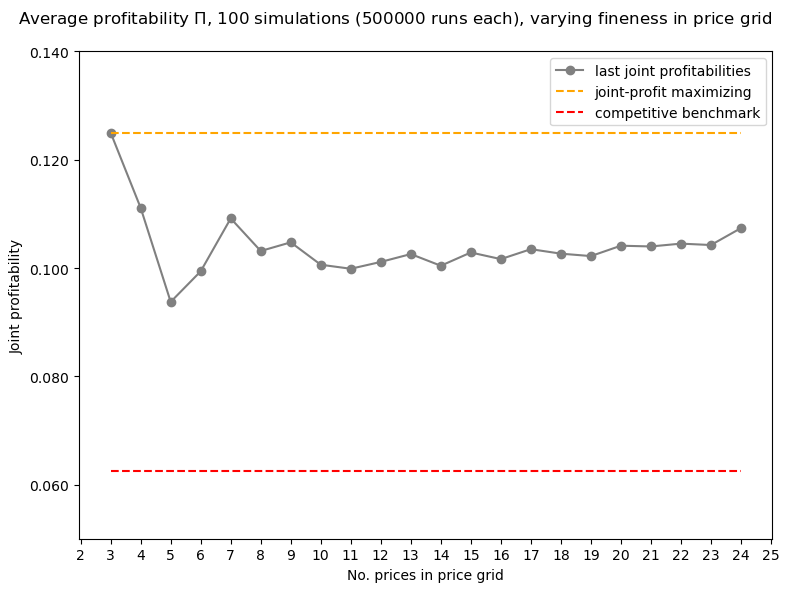

In [17]:
fig, axs = plt.subplots(1)
fig.suptitle("Average profitability $\Pi$, 100 simulations (500000 runs each), varying fineness in price grid")
fig.set_figheight(6)
fig.set_figwidth(8)
axs.set_xlabel("No. prices in price grid")
axs.set_ylabel("Joint profitability")
axs.set_ylim(0.050, 0.140)
axs.plot(num_prices, avg_last_joint_profitabilities, color="grey", label = "last joint profitabilities", marker='o')
axs.plot(num_prices, [0.125]*len(num_prices), color='orange', label='joint-profit maximizing', linestyle='dashed')
axs.plot(num_prices, [0.0625]*len(num_prices), color='red', label='competitive benchmark', linestyle='dashed')
axs.xaxis.set_major_locator(ticker.MultipleLocator(1))
axs.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
fig.tight_layout()
plt.legend()
#plt.show()
plt.savefig("num_prices.png")